In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm, shapiro

from matplotlib import pyplot as plt

import os

In [ ]:
CELL_LAT, CELL_LON = 35.734341, 51.582401

In [3]:
DATA_PATH = os.path.join("Data", "canopus_dataV1.csv")
data = pd.read_csv(DATA_PATH)

In [4]:
data.drop(['mcc', 'mnc', 'tac'], axis=1, inplace=True)
data = data[data['source'] == "LTE_registered"].reset_index(drop=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  626 non-null    object 
 1   latitude   626 non-null    float64
 2   longitude  626 non-null    float64
 3   cellId     626 non-null    int64  
 4   rsrp       626 non-null    int64  
 5   source     626 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 29.5+ KB


In [7]:
data.value_counts('cellId')

cellId
44809544    126
43902487    125
43902231     76
43902477     70
43861771     45
44512032     33
43902537     32
44512023     27
43902527     26
43902232     22
43902486     15
43902221     12
44809494     12
23366157      3
43861831      1
44809484      1
Name: count, dtype: int64

In [8]:
cell_data = data[data['cellId'] == 43902477].reset_index(drop=True)

In [ ]:
cell_data.describe()

In [9]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

cell_data["distance_m"] = cell_data.apply(lambda row: haversine(row["latitude"], row["longitude"], CELL_LAT, CELL_LON), axis=1)


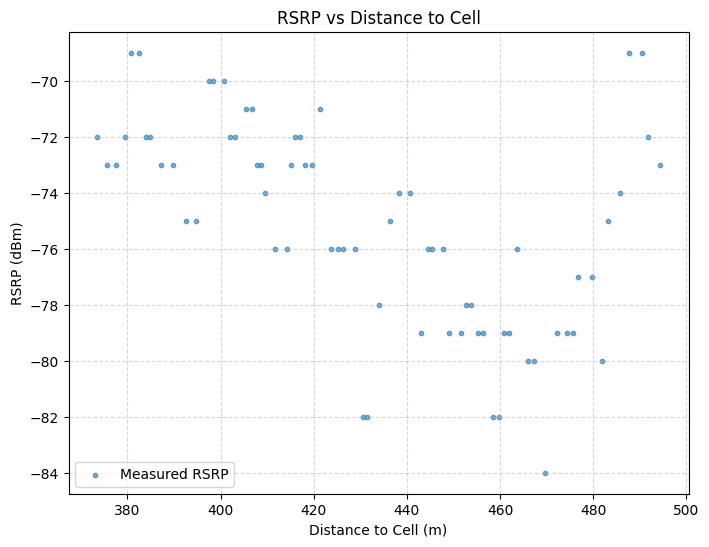

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(cell_data["distance_m"], cell_data["rsrp"], s=10, alpha=0.6, label="Measured RSRP")

plt.xlabel("Distance to Cell (m)")
plt.ylabel("RSRP (dBm)")
plt.title("RSRP vs Distance to Cell")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


IQR

In [11]:
Q1 = cell_data["rsrp"].quantile(0.25)
Q3 = cell_data["rsrp"].quantile(0.75)
IQR = Q3 - Q1

cell_data_clean = cell_data[(cell_data["rsrp"] >= Q1 - 1.5*IQR) & (cell_data["rsrp"] <= Q3 + 1.5*IQR)]


In [12]:
cell_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   70 non-null     object 
 1   latitude    70 non-null     float64
 2   longitude   70 non-null     float64
 3   cellId      70 non-null     int64  
 4   rsrp        70 non-null     int64  
 5   source      70 non-null     object 
 6   distance_m  70 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 4.0+ KB


In [13]:
# x = log10(distance)
cell_data_clean["log_distance"] = np.log10(cell_data_clean["distance_m"])

# y = RSRP
x = cell_data_clean["log_distance"]
y = cell_data_clean["rsrp"]

# Linear Regression
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

a, b = model.params
beta = -b / 10    # β Estimation

# σ Estimation
residuals = model.resid
sigma = residuals.std()

print(f"β (Path Loss Exponent) ≈ {beta:.3f}")
print(f"σ (Shadowing Std) ≈ {sigma:.3f} dB")

# print(model.summary())


β (Path Loss Exponent) ≈ 5.625
σ (Shadowing Std) ≈ 3.148 dB


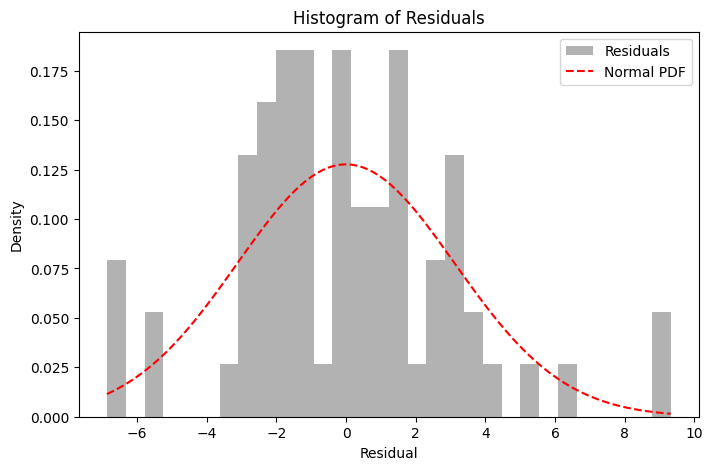

Shapiro-Wilk test: statistic=0.963, p-value=0.039


In [14]:
# Residual histogram
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color="gray", label="Residuals")


# Normal PDF with same mean and std
mu, std = np.mean(residuals), np.std(residuals)
x = np.linspace(min(residuals), max(residuals), 100)
plt.plot(x, norm.pdf(x, mu, std), "r--", label="Normal PDF")
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.legend()
plt.show()


stat, p = shapiro(residuals)
print(f"Shapiro-Wilk test: statistic={stat:.3f}, p-value={p:.3f}")
